<a href="https://colab.research.google.com/github/nirwanaz/ml/blob/main/xauusd_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta
!pip install joblib
!pip install tensorflow

In [ ]:
import pandas as pd
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import AverageTrueRange, BollingerBands
from ta.volume import OnBalanceVolumeIndicator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
import joblib
import os

In [ ]:
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['rsi'] = RSIIndicator(df['close']).rsi()
    df['stoch_k'] = StochasticOscillator(df['high'], df['low'], df['close']).stoch()
    df['macd'] = MACD(df['close']).macd()
    df['cci'] = CCIIndicator(df['high'], df['low'], df['close']).cci()
    df['bb_bbm'] = BollingerBands(df['close']).bollinger_mavg()
    df['atr'] = AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()
    df['obv'] = OnBalanceVolumeIndicator(df['close'], df['tick_volume']).on_balance_volume()
    df['williams_r'] = WilliamsRIndicator(df['high'], df['low'], df['close']).williams_r()
    df['ema_20'] = df['close'].ewm(span=20, adjust=False).mean()

    return df.dropna()

In [ ]:
def label_signals(df, lookahead=10, threshold=0.5):
    labels = []
    close = df['close'].values
    atr = df['atr'].values

    for i in range(len(df) - lookahead):
        entry = close[i]
        current_atr = max(atr[i], 0.05)
        dyn_threshold = current_atr * threshold

        future_prices = close[i+1:i+1+lookahead]
        max_up = np.max(future_prices - entry)
        max_down = np.min(entry - future_prices)

        if max_up >= dyn_threshold and max_up > max_down:
            labels.append(2)  # LONG
        elif max_down >= dyn_threshold and max_down > max_up:
            labels.append(1)  # SHORT
        else:
            labels.append(0)  # HOLD

    df = df.iloc[:len(labels)].copy()
    df['signal'] = labels
    return df


In [ ]:
def prepare_data(df, features, window_size=30, lookahead=10, threshold=0.05):
    df = label_signals(df, lookahead=lookahead, threshold=threshold)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features])
    X, y = [], []

    for i in range(window_size, len(scaled_features)):
        X.append(scaled_features[i - window_size:i])
        y.append(df['signal'].iloc[i])

    return np.array(X), np.array(y), scaler

In [ ]:
def build_lstm_model(input_shape, lstm_units_1=64, lstm_units_2=32, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Tambahkan Input layer di sini
    model.add(LSTM(lstm_units_1, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units_2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def tune_model(X_train, y_train, X_val, y_val, param_grid, n_iter=10, save_dir="models"):
    os.makedirs(save_dir, exist_ok=True)
    best_accuracy = 0
    best_model = None
    best_params = {}

    param_combinations = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))

    for i, params in enumerate(param_combinations):
        print(f"\nTraining model {i+1}/{n_iter} with params: {params}")

        # Create optimizer with learning rate
        if params['optimizer'] == 'adam':
            optimizer = Adam(learning_rate=params['learning_rate'])
        else:
            optimizer = RMSprop(learning_rate=params['learning_rate'])

        # Build model
        model = build_lstm_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            lstm_units_1=params['lstm_units_1'],
            lstm_units_2=params['lstm_units_2'],
            dropout_rate=params['dropout_rate'],
            optimizer=optimizer
        )

        # Setup callbacks
        checkpoint_path = os.path.join(save_dir, f"model_{i+1}.keras")
        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True),
            ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max'),
            ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
        ]

        # # Hitung class weight
        # y_labels = np.argmax(y_train, axis=1)
        # class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
        # class_weights_dict = dict(enumerate(class_weights))

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            # class_weight=class_weights_dict,
            callbacks=callbacks,
            verbose=0
        )

        val_acc = max(history.history["val_accuracy"])
        print(f"Model {i+1} - Best val accuracy: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model = model
            best_params = params

    print("\nBest validation accuracy:", best_accuracy)
    print("Best parameters:", best_params)
    return best_model, best_params


In [ ]:
def load_data():
  df = pd.read_csv('XAUUSD_M5.csv')
  df.columns = df.columns.str.lower()
  df['time'] = pd.to_datetime(df['time'])
  df.set_index('time', inplace=True)
  return df

In [ ]:
def run_backtest(df, predictions, stop_loss=30, take_profit=50, transaction_cost=0.0005, allow_short=True):
    stop_loss /= 10000
    take_profit /= 10000

    df_backtest = df.iloc[-len(predictions):].copy()
    df_backtest['predicted_signal'] = predictions
    df_backtest['market_return'] = df_backtest['close'].pct_change()
    df_backtest['entry_price'] = df_backtest['close'].shift(1)
    df_backtest['trade_return'] = 0.0
    df_backtest['trade_executed'] = 0
    df_backtest.dropna(inplace=True)

    for i in range(1, len(df_backtest)):
        signal = df_backtest.iloc[i - 1]['predicted_signal']
        entry_price = df_backtest.iloc[i - 1]['entry_price']
        current_price = df_backtest.iloc[i]['close']

        if signal == 2:  # Long
            pnl = (current_price - entry_price) / entry_price
            if pnl >= take_profit or pnl <= -stop_loss:
                df_backtest.at[df_backtest.index[i], 'trade_return'] = pnl
                df_backtest.at[df_backtest.index[i], 'trade_executed'] = 1
        elif signal == 1 and allow_short:  # Short
            pnl = (entry_price - current_price) / entry_price
            if pnl >= take_profit or pnl <= -stop_loss:
                df_backtest.at[df_backtest.index[i], 'trade_return'] = pnl
                df_backtest.at[df_backtest.index[i], 'trade_executed'] = 1

    # Strategy return: only when signal active
    df_backtest['strategy_return'] = 0.0
    df_backtest.loc[df_backtest['predicted_signal'] == 2, 'strategy_return'] = df_backtest['market_return']
    df_backtest.loc[df_backtest['predicted_signal'] == 1, 'strategy_return'] = -df_backtest['market_return']

    # Transaction cost
    df_backtest['position_change'] = df_backtest['predicted_signal'].diff().abs()
    df_backtest['strategy_return'] -= df_backtest['position_change'] * transaction_cost

    # Cumulative returns
    df_backtest['cumulative_strategy_return'] = (1 + df_backtest['strategy_return']).cumprod()
    df_backtest['cumulative_market_return'] = (1 + df_backtest['market_return']).cumprod()

    # Save & Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_backtest['cumulative_strategy_return'], label='Strategy Return')
    plt.plot(df_backtest['cumulative_market_return'], label='Market Return')
    plt.title("Backtest Performance")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("strategy_backtest_chart.png")
    plt.show()

    df_backtest[df_backtest["trade_executed"] == 1].to_csv("executed_trades.csv", index=False)

    print("✅ Backtest chart saved as strategy_backtest_chart.png")
    print("✅ Executed trades saved as executed_trades.csv")

    return df_backtest

In [ ]:
def evaluate_backtest(df_backtest):
    df = df_backtest.dropna(subset=["strategy_return", "cumulative_strategy_return", "trade_return", "trade_executed"])

    final_return = df["cumulative_strategy_return"].iloc[-1] - 1
    peak = df["cumulative_strategy_return"].cummax()
    drawdown = (df["cumulative_strategy_return"] - peak) / peak
    max_drawdown = drawdown.min()

    # Sharpe Ratio
    sharpe = df["strategy_return"].mean() / df["strategy_return"].std() * np.sqrt(252 * 24 * 4)  # M15

    # Win Rate
    executed = df[df["trade_executed"] == 1]
    if not executed.empty:
        win_rate = len(executed[executed["trade_return"] > 0]) / len(executed)
    else:
        win_rate = np.nan

    # Profit to Loss Ratio
    profits = executed[executed["trade_return"] > 0]["trade_return"]
    losses = executed[executed["trade_return"] < 0]["trade_return"].abs()
    plr = profits.mean() / losses.mean() if not losses.empty else np.nan

    print("📊 Backtest Evaluation:")
    print(f"📈 Final Return          : {final_return:.2%}")
    print(f"📉 Max Drawdown         : {max_drawdown:.2%}")
    print(f"⚖️  Sharpe Ratio          : {sharpe:.2f}")
    print(f"✅ Win Rate             : {win_rate:.2%}")
    print(f"💰 Profit/Loss Ratio     : {plr:.2f}")

Trying window size: 20
Hold (0): 19016 (38.07%)
Short (1): 3983 (7.97%)
Long (2): 26951 (53.96%)

Training model 1/4 with params: {'optimizer': 'rmsprop', 'lstm_units_2': 32, 'lstm_units_1': 128, 'learning_rate': 0.0005, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 16}

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Model 1 - Best val accuracy: 0.5346

Training model 2/4 with params: {'optimizer': 'adam', 'lstm_units_2': 32, 'lstm_units_1': 64, 'learning_rate': 0.0005, 'epochs': 50, 'dropout_rate': 0.2, 'batch_size': 32}

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Model 2 - Best val accuracy: 0.5346

Training model 3/4 with params: {'optimizer': 'adam', 'lstm_units_2': 32, 'lstm_units_1': 64, 'learning_rate': 0.001, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 16}

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Model 3 - Best val accuracy: 0.5346

Training model 4/4 with params: {'optimiz

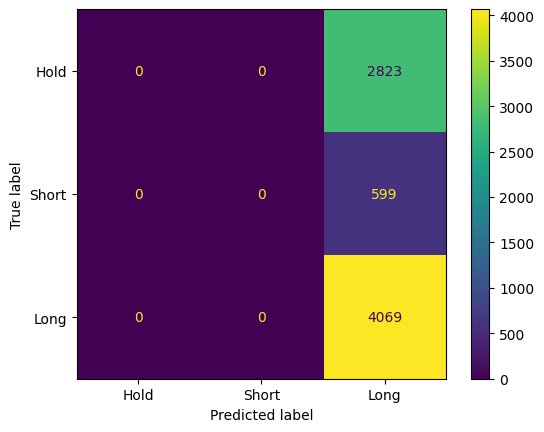

In [ ]:
params = {
    "lookback": 60,
    "dropna": True,
    "indicators": ['close', 'rsi', 'stoch_k', 'macd', 'cci', 'bb_bbm', 'atr', 'obv', 'williams_r', 'ema_20'],
    "model": {
        "early_stopping": True,
        "patience": 5,
        "use_attention": True,
        "bidirectional": True
    },
}

df = load_data()
df = add_indicators(df)
features = params["indicators"]

# Define param grid
param_grid = {
    "lstm_units_1": [32, 64, 128],
    "lstm_units_2": [32, 64],
    "dropout_rate": [0.2, 0.3],
    "optimizer": ["adam", "rmsprop"],
    "batch_size": [16, 32],
    "epochs": [20, 50],
    "learning_rate": [0.001, 0.0005]
}

best_model = None
best_params = None
best_window_size = None
best_score = 0

for window_size in [20, 30]:
    print(f"Trying window size: {window_size}")
    # Preprocess
    X, y, scaler = prepare_data(df, features, window_size=window_size, lookahead=5, threshold=0.5)
    unique, counts = np.unique(y, return_counts=True)
    label_names = {0: "Hold", 1: "Short", 2: "Long"}

    for label, count in zip(unique, counts):
        print(f"{label_names[label]} ({label}): {count} ({count / len(y):.2%})")

    joblib.dump(scaler, "scaler.save")

    # Encode labels to one-hot
    y_cat = to_categorical(y, num_classes=3)
    total_samples = len(X)
    train_end = int(total_samples * 0.7)
    val_end = int(total_samples * 0.85)

    X_train, y_train = X[:train_end], y_cat[:train_end]
    X_val, y_val = X[train_end:val_end], y_cat[train_end:val_end]
    X_test, y_test = X[val_end:], y_cat[val_end:]

    model, params = tune_model(
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        param_grid=param_grid,
        n_iter=4)

    test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f"Test accuracy (window size: {window_size}): {test_acc:.4f}")

    if test_acc > best_score:
        best_model = model
        best_params = params
        best_window_size = window_size
        best_score = test_acc

print(f"Best window size: {best_window_size}")
print(f"Best params: {best_params}")
print(f"Best score: {best_score}")

# Predict & Evaluate
y_pred = best_model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
ConfusionMatrixDisplay(cm, display_labels=["Hold", "Short", "Long"]).plot()
plt.show()

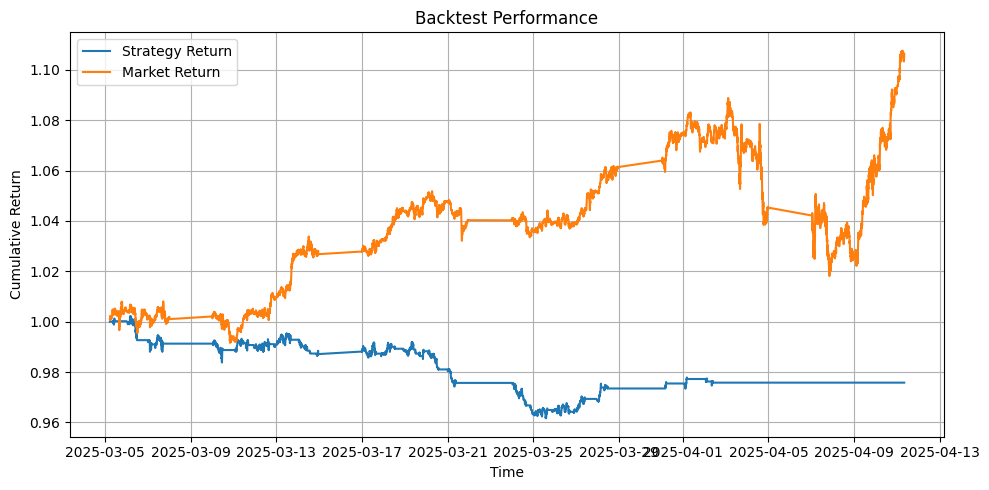

✅ Backtest chart saved as strategy_backtest_chart.png
✅ Executed trades saved as executed_trades.csv
📊 Backtest Evaluation:
📈 Final Return          : -2.42%
📉 Max Drawdown         : -4.05%
⚖️  Sharpe Ratio          : -2.14
✅ Win Rate             : 0.00%
💰 Profit/Loss Ratio     : nan


In [ ]:
params = {
    "backtest": {
        "stop_loss": 25,
        "take_profit": 50,
        "transaction_cost": 0.0003,
        "use_short": True
    }
}

backtest_params = params["backtest"]
df_backtest = df.iloc[-len(y_pred_labels):].copy()
df_result = run_backtest(
                    df,
                    y_pred_labels,
                    stop_loss=backtest_params["stop_loss"],
                    take_profit=backtest_params["take_profit"],
                    transaction_cost=backtest_params["transaction_cost"],
                    allow_short=backtest_params["use_short"])
evaluate_backtest(df_result)